In [2]:
import os
import sys

sys.path.append("..")  # Avoid error with importing of src
from src.utils_py.substr import generate_substrate, generate_calcite_itp, get_calcite_neighbors_list_numpy, get_calcite_neighbors_list
from src.utils_py.io.gro import read_gro

In [6]:
path = '../substrates/calcite/calcite_104_unitcell.gro'

In [7]:
# name = generate_substrate(path, 5, 5, 5)
name = generate_substrate(path, 20, 5, 4)

Possible substrate size 18.0x4.8x3.7
Substrate successfully created!


In [10]:
name

'calcite_104_1x4x1.gro'

In [7]:
0.002 * 5000000

10000.0

In [8]:
''.join([i for i in 'CCA1' if not i.isdigit()])

'CCA'

In [9]:
'{:>.2e}'.format(12.123044132)

'1.21e+01'

In [15]:
from itertools import combinations

for i, j in list(combinations([1, 2, 3], 2)):
    print(i, j)

1 2
1 3
2 3


In [3]:
path = '../substrates/calcite/gro/calcite_104_2x3x4.gro'
substr = read_gro(path)

In [7]:
neigh_dict = get_calcite_neighbors_list(substr)

Generating neighbors list


100%|██████████| 7680/7680 [00:43<00:00, 176.18it/s]


In [8]:
neigh_dict_numpy = get_calcite_neighbors_list_numpy(substr)

100%|██████████| 7680/7680 [00:00<00:00, 1928762.03it/s]


Generating neighbors list


100%|██████████| 1536/1536 [00:00<00:00, 3163.77it/s]


In [9]:
neigh_dict == neigh_dict_numpy

True

In [11]:
os.path.split(os.path.split(path)[0])[0]

'../substrates/calcite'

In [9]:
substrate_itp = generate_calcite_itp(path)

100%|██████████| 25920/25920 [00:00<00:00, 2050981.19it/s]


Generating neighbors list


100%|██████████| 25920/25920 [00:04<00:00, 5254.79it/s]


In [13]:
substrate_itp

'calcite_104_1x4x1.itp'

In [34]:
freeze_substr = False
ansambel = 'npt'

assert (
    not freeze_substr or ansambel != "npt"
), "Can not run npt with freeze substr"

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
time1, pot1, temp1, press1, box_x1, box_y1, box_z1 = np.loadtxt("../data/energy_1.xvg", comments=["@", "#"], unpack=True)

In [57]:
time100, pot100, temp100, press100, box_x100, box_y100, box_z100 = np.loadtxt("../data/energy_100.xvg", comments=["@", "#"], unpack=True)

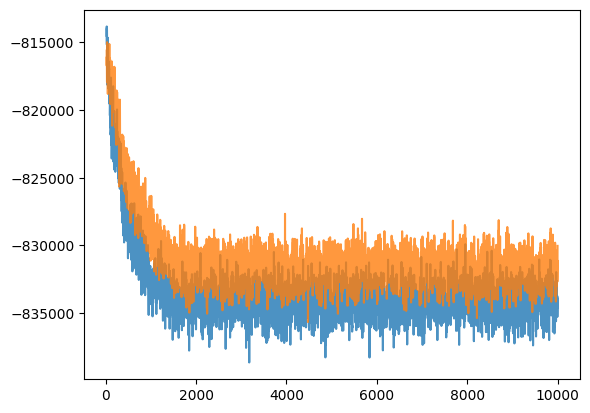

In [67]:
begin = 10
plt.plot(time1[begin:], pot1[begin:], alpha=0.8)
plt.plot(time100[begin:], pot100[begin:], alpha=0.8)
plt.show()

In [68]:
arr = np.arange(1, 11, dtype=int)
arr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [69]:
mask = np.array([3, 4, 5])

In [75]:
np.argwhere((arr[mask] - 2) < 3).ravel()

array([0])